In [45]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import random
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.WARNING)

df = pd.read_csv("creditcard.csv")

#data cleaning
#starting with duplicates
df.drop_duplicates(inplace=True)

"""frauds are also outliers there you cannot drop the outliers
"""
# #turning outlier values into NaN values
# for column in df.columns:
#     q1 = df[column].quantile(0.25)
#     q3 = df[column].quantile(0.75)
#     iqr = q3 - q1
#     lowerBound = q1 - 1.5 * iqr
#     upperBound = q3 + 1.5 * iqr

#     df[column] = df[column].apply(lambda x: float("NaN") if not lowerBound <= x <= upperBound else x)

#dropping NaN values
df.dropna(inplace=True)

In [46]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [47]:
def predict(dataFrame, boolUndersample, percentageUndersample, boolOversample, columnName):
    if(boolUndersample):
        size = len(dataFrame[dataFrame["Class"] == 0])
        df2 = dataFrame[dataFrame["Class"] == 0].sample(round(size * (percentageUndersample / 100)))
        df3 = dataFrame[dataFrame["Class"] == 1]
        dataFrame = pd.concat([df2, df3], ignore_index=True)

    X = dataFrame.drop(columnName, axis=1)
    y = dataFrame[columnName]
    if(boolOversample):
        smote = SMOTE(random_state= 42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lightgbm = lgb.LGBMClassifier(n_estimators=150, random_state=42, learning_rate=0.2, objective="binary", n_jobs=2)
    lightgbm.fit(X_train, y_train)
    y_prediction = lightgbm.predict(X_test)
    accuracy = accuracy_score(y_test, y_prediction)
    precision = precision_score(y_test, y_prediction)
    recall = recall_score(y_test, y_prediction)
    f1 = f1_score(y_test, y_prediction)
    roc_auc = roc_auc_score(y_test, y_prediction)
    scoresDict = {
        "Accuracy_score":accuracy,
        "Precision_score":precision,
        "Recall_score":recall,
        "f1_score":f1,
        "rocAuc_score":roc_auc
    }
    return scoresDict
    

[LightGBM] [Info] Number of positive: 387, number of negative: 45312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 45699, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008468 -> initscore=-4.762902
[LightGBM] [Info] Start training from score -4.762902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

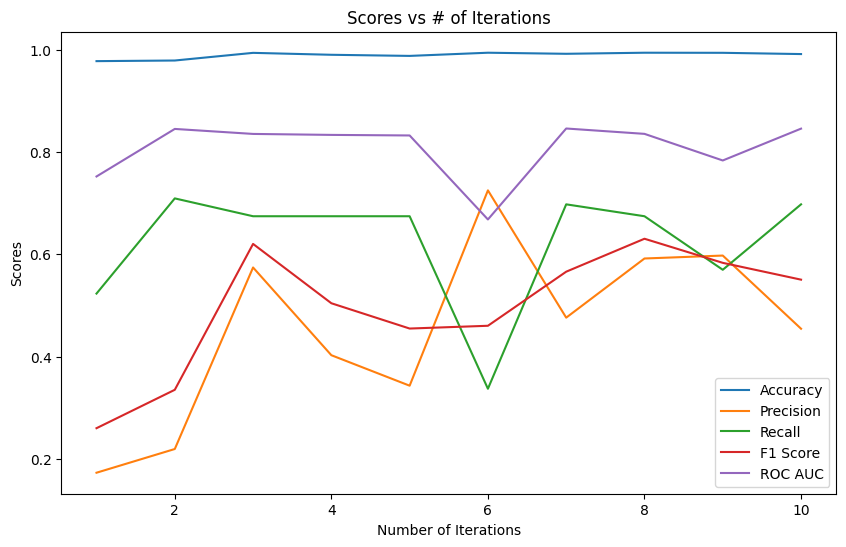

In [48]:
#Visualising the scores of the lightgbm model
def linePlotVisualisation(dataFrame, boolUndersample, percentageUndersample, boolOversample, columnName):
    accuracyScores = []
    precisionScores = []
    recallScores = []
    f1Scores = []
    rocAucScores = []

    for _ in range(10):
        scores_dict = predict(df, True, 20, False, "Class") 
        accuracyScores.append(scores_dict["Accuracy_score"])
        precisionScores.append(scores_dict["Precision_score"])
        recallScores.append(scores_dict["Recall_score"])
        f1Scores.append(scores_dict["f1_score"])
        rocAucScores.append(scores_dict["rocAuc_score"])

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), accuracyScores, label="Accuracy")
    plt.plot(range(1, 11), precisionScores, label="Precision")
    plt.plot(range(1, 11), recallScores, label="Recall")
    plt.plot(range(1, 11), f1Scores, label="F1 Score")
    plt.plot(range(1, 11), rocAucScores, label="ROC AUC")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Scores")
    plt.title("Scores vs # of Iterations")
    plt.legend()
    plt.show()

linePlotVisualisation(df, True, 20, False, "Class")
